# Capstone Project: Word2Vec for Recommendation Systems

> Generating movie recommendations using word2vec

# Definition

## Project Overview

This project aims to show how [Word2vec](https://en.wikipedia.org/wiki/Word2vec) can be used to build recommendation systems.

A [recommendation system](https://en.wikipedia.org/wiki/Recommender_system) seeks to predict which items a given user would more likelly interact with (click, buy, listen, watch and etc) based on previous interactions made by him or by similar users. This is a big area of interest for research and industry due to its comproved efficacy to increase user engagement and per user revenue. As an example, Netflix estimates that more than 80% of shows people watch on their platform are discovered throught their recommendation systems ([source](https://www.wired.co.uk/article/how-do-netflixs-algorithms-work-machine-learning-helps-to-predict-what-viewers-will-like)).

Word2Vec is a set of technhiques to generate word embeddings for NLP tasks. Its main advantages over other NLP tecnhiques it that it learns the context of words in a sentence based on the surroundings of other words, an illustration of this ability is that the algorithm could understand when the word Buffalo is used to mean the animal buffalo or the city "Buffalo" in the state of New York in a sentence. It does this by representing the words in a multi-dimensional space (embeddings) and these embeddings have the property that the distance between the embeddings is a signal of its similarity.

The dataset used for this project is the [MovieLens](https://grouplens.org/datasets/movielens/), it is probably the most famous and used dataset for recommendation systems. Most libraries for recommendation systems and research articles use this dataset, so this simplifies the benchmarking.


The final project I implemented differed from my original proposal on the following points:

* Dataset

    I initially planed to develop this project against the ["Expedia Hotel Recommendations Kaggle competition"](https://www.kaggle.com/c/expedia-hotel-recommendations/data), however this dataset showed difficult to work due to its size, complexity of features and lack of articles. So after a time spent on EDA, I concluded that using a more common dataset for recommendations systems would be simpler to develop and to benchmark. For this reason, I decided to use the famous [MovieLens](https://grouplens.org/datasets/movielens/) dataset.

    Also, the main benefit in my opinion to use a Kaggle competion for this project was the possibility to easily benchmark my results against the leaderboard. But since my proposal is to demonstrate how a tecnhique of a different domain (NLP), can be used for recommendation systems, I dont expect that my final solution will beat purpose built algorithms.


* Algorithm

    My first idea was to build a custom model in PyTorch to generate the embeddings. However, I ended up using [Gensim](https://radimrehurek.com/gensim/) a common library for word2vec. This approach allowed me to focus more on the technique and in other parts of my project.



## Problem Statement

This problem is defined as: Applying Word2Vec to learn similar movies using the MovieLens dataset.

This dataset is derived from the [MovieLens platform](https://movielens.org/), there users can rate and review movies they have watched, get rich information about movies and receive recommendations of movies to watch next.

In this project I used the smaller version of the dataset called MovieLens100K which contains 100000 of ratings of 9000 movies, made by 600 users ([link for dataset](https://grouplens.org/datasets/movielens/latest/)).

The goal here is to demonstrate how a tecnhique of NLP can be abbused to generate recommendations, I explore ways to serve the recommendations based on embeddings in a scalable way and I also create a sample application to visualize the generated recommendations.

I dont intend to produce state of the art results, but simply demonstrate a good enough and simple tecnhique to generate recommendations.

## Metrics

The main metric I used to evaluate my model was "Average Precision at k" ([source](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Average_precision)). This is a common metric used by recommendation systems and also simple to calculate.

Since the recommendation system I built suggests similar items (item-to-item) and the MovieLens dataset doesn't have a groundtruth dataset for item similarity, I calculated the metric using the following approach: 

1. Isolated X% of my users to use for evaluation
1. For each user U I selected all his positive movie ratings MR
1. For each MR I calculated 5 suggestions for the movie rated
1. I checked if the suggested movies were inside the MR, if so, I considered it as a match. I calculated the precision P for each recommendation.
1. I sumed all P and divided by the number of users to have my final average precision at 5.

The source code for the way I calculated this metric can be found [here](TODO).

# Analysis

## Data Exploration

The data exploration I performed for this project can be found on the notebook [10_eda](./10_eda.ipynb).

The dataset used is the MovieLens 100k. It contains the following files:

In [ ]:
!ls -hl ../data/ml-latest-small

total 6472
-rw-r--r--  1 felipe.gasparini  2119619082   8.1K Sep 26  2018 README.txt
-rw-r--r--  1 felipe.gasparini  2119619082   193K Sep 26  2018 links.csv
-rw-r--r--  1 felipe.gasparini  2119619082   483K Sep 26  2018 movies.csv
-rw-r--r--  1 felipe.gasparini  2119619082   2.4M Sep 26  2018 ratings.csv
-rw-r--r--  1 felipe.gasparini  2119619082   116K Sep 26  2018 tags.csv


In this project I focused on the `ratings.csv` file since it had the the user interactions, which is what I needed to train my model.

In [ ]:
import pandas as pd

In [ ]:
ratings_df = pd.read_csv("../data/ml-latest-small/ratings.csv")
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
ratings_df.shape

(100836, 4)

The ratings dataset is quite simple. It consists of the userId, movieId, rating and timestamp.

There are over 100000 ratings in the dataset and they are not evenly distributed across the dimensions: users, movies and ratings, as we can observe:

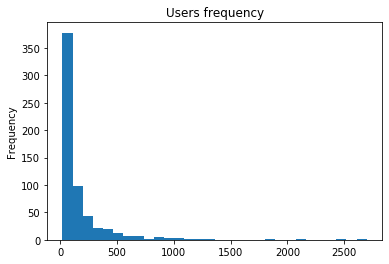

In [ ]:
ratings_df["userId"].value_counts().plot(kind='hist', bins=30, title="Users frequency")

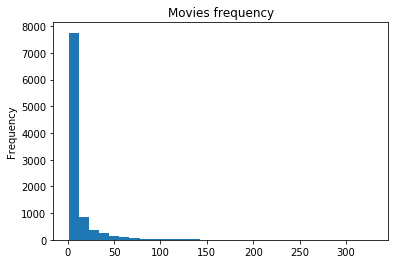

In [ ]:
ratings_df["movieId"].value_counts().plot(kind='hist', bins=30, title="Movies frequency")

We can observe a few properties that are common in recommendation systems:

1. few users generates most of the interactions
1. few items concetrate most of the interactions

The second property is referenced as long-tail, and it is common for recommender systems to learn to recommend just the most popular items (this is know as the richer-get-richer problem) and perform well during evaluation and in production, but depending of the business, it may be interesting to diversify more the recommendations. The property of a recommender system to provide diverse recommendations is called serendipity and there is a huge collection of research articles about this ([source](https://scholar.google.de/scholar?q=recommender+systems+serendipity&hl=en&as_sdt=0&as_vis=1&oi=scholart)).

To illustrate this property in this domain (movies), consider the movie "The Lord of the Rings - A fellowship of the Ring", users that saw this movie intuitivelly are more likelly to also watch the other movies of the "Lord of the Rings" franchise and "The Hobbit", so these recommendations are obvious.

I'm not planning to tackle the serendipity problem here.

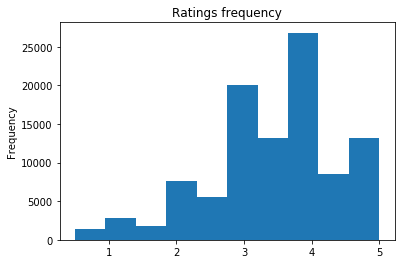

In [ ]:
ratings_df["rating"].plot(kind='hist', title="Ratings frequency")

In [ ]:
ratings_df_with_positive = ratings_df
ratings_df_with_positive["is_positive_review"] = ratings_df_with_positive["rating"] >= 3.0
ratings_df_with_positive["is_positive_review"].value_counts()

True     81763
False    19073
Name: is_positive_review, dtype: int64

I used the threshold value of 3 to consider a review as positive. Since I only use positive reviews in my model, this removed almost 20000 ratings from the dataset.

### Algorithms and Techniques

This project is unusual since I dont try to find the best machine learning model and tune it against a metric. Here I try to apply to recommendation systems a tecnhnique from Natural Language Processing.

There are two techniques I'm using here:

1. Generate item embeddings using Word2Vec
1. Find similar items (generate recommendations) with embeddings

#### Generate item embeddings

There are multiple ways to generate [embeddings](https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526), word2vec is just one approach to it.

Word2vec works by learning the context of words in a sentence. So the problem I had to solve was to how to generate a sentence to use for training.

A usual sentence for word2vec is something like: 'A rabbit is in a hole', so a sentence is a real language sentence. The first approach I used was to form sentences for each review using the movieId and the genres of the movie, so a sentence was "8217312 action drama", this didnt work well: instead of learning the similarities between movies (movieIds) it actually learned the similarities across categories. Which was not what I intended and not very useful.

After a few more interations I generated sentences using the following algorithm:

1. sort all interactions by userId and timestamp. So all interactions of a user are together and they are sorted by timestamp
1. create a sentence consisting of all movies a user has rated

With this approach, a sample sentence has this format: "318391 2312 123923 763 6123".

The assumption I made was that users watch and review similar movies close to each other, so the word2vec model should learn how frequent these movies are watched together and create embeddings that represent these similarities.

#### Find similar items using embeddings

The output of the model training are embeddings. To generate recommendations for a movie, I have to get its representation as embedding, search for the K closest embeddings and for each of the embeddings found, discover the movieId for this movie.

The problem of finding the K closest embeddings is just classic problem to find the [K Nearest Neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm). 

For this project, I implemented a recommender ([source](./02_recommender.ipynb)) completely decoupled from the Gensim library (the library used to generate the embeddings). This approach allows the separation between training and predicting. This can simplify the deployment since you dont need to include in your runtime the libraries used for training. Since the recommender is decoupled from Gensim, it could also be used to servce recommendations created by other models that also generate embeddings.

Also, KNN scales linearly with the cardinality of the embeddings, so for problems with milions or billions of embeddings, a naive approach of KNN would not work - it would take too long to produce any recommendation. This is an interesting topic and industry are tackling this problem with creative ways: Facebook created a library for performatic aproximate KNN search called FAISS (https://github.com/facebookresearch/faiss) and other companies, are storing the embeddings in search engines like Solr to levarege its distributed nature to speed up queries.


### Benchmark

The MovieLens dataset is widely used for recommendation systems, so benchmarks are widely available. Microsoft maintains this [repository](https://github.com/microsoft/recommenders) with several benchmarks of recommendation systems applied in the MovieLens dataset. 

My initial idea is that I could simply compare the results I got against this [benchmark](https://github.com/microsoft/recommenders/blob/master/benchmarks/movielens.ipynb), however, it turned out more difficult than expected due to how I calculate my metrics or the need to standartize my model training using this benchmark parameters.

Due to time constraints I didnt have time to benchmark the performance of my recommendation system. However, since my goal is to demonstrate the tecnhique, I was not considering the benchmark as a must have in this project.

Also, offline metrics hardly correlates to online metrics for recommendations systems. This is due to how subjective relevance is to every person. 

I created one web application ([source](./04_dash.ipynb)) to visualise recommendations for a movie. This was also useful to demonstrate how to deploy this model in production.

## Methodology

### Data Preprocessing

The dataset with ratings was already clean (no NAs or missing data).

I added these extra pre-processing steps in my solution:

1. Remove negative ratings: I removed all ratings less than 3.0. This step was not needed for my model (since it learns similarities between movies), however, it made sense to me to exclude bad ratings to don't polute with bad movies.
1. Generate sentences: I described the needed for this and the approach under [Algorithm and Techniques](#Generate-item-embeddings).
1. Isolate 10% of users for evaluation. I'm isolating users and all its interactions.

The code for data processing can be found [here](./01_model.ipynb).

### Implementation

#### Model and Training

All code related to the model and training are in the [model notebook](./01_model.ipynb). Please, refer there for examples of usage and evaluation.

I used the [Gensim library](https://radimrehurek.com/gensim/) - which is a very popular Word2Vec library for Python - to generate the movie embeddings. I already had prior experience with this library, so when I realised that creating my own model would be too much effort for this project, the decision to use Gensim was no-brainer. 

The main challenge was to create sentences in a way that the Word2Vec model would learn something meaningful, it took me several attempts until I had something that worked well.

To simplify things, I created a class "Word2VecMovieModel" that encapsulates all the steps regarding model training, evaluation and serialization of model.


Initially I trained a model with default hyper-parameter values, I analised if the recommendations made sense to have a feel if my approach was working, and it was. For this model, I got a P@5 of 0.17. 

Knowing that my approach made sense, I was interested in improving the performance of my model. I created the function `hyper_parameter_tunning` to try different combinations of hyper-parameters and select the best one. The only parameters I permuted were: number of epochs, window size (the length of words in a sentence the word2vec considers in a context) and negative (for negative sampling).

By automating the tunning of the model, I didn't have to understand every single aspect of the Word2Vec model and the implementation details of Gensim.

The best model I got with this technique had P@5 of 0.26, over 50% of improvement over the naive model.

With the best model in hands, I saved it to disk, so I could reuse it for the next steps.

I also calculate the coverage (how many distinct items my recommender can recommend) and I got a coverage of 29%.


#### Predicting (aka generating recommendations)

All code related to generating recommendations are in the [recommender notebook](./02_recommender.ipynb). Please, refer there for examples of code.

To serve recommendations, two approaches can be taken: 
1. Generate all recommendation in batch and store it and serve from storage 
1. Or Generate the recommendations on-line

The first approach works really well when the model is too complex to deploy and the cardinality of items is low, so a batch job to generate all recommendations up-front makes a lot of sense. This is actually the case in this project since the cardinality is low, only 10000 items.

However, I decided to implement an online recommender to show how to serve recommendations from embeddings. For this I created the class `KnnRecommender` that had as dependency just the embeddings and the word indexes (of list of all the movieIds ordered by index in the embedding).

This means that this Recommender is decoupled from the model, so even if I changed how to generate embeddings I could still reuse this part to produce recommendations. Another benefit, is that my serving application will not need to have Gensim installed.

To quickly calculate the KNN for an embedding I used the [NearestNeighbors](https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-nearest-neighbors) from Scikit-learn. This implementation is quite efficient and can scale well even for high cardinalities, however, if we the cardinality was already above a few million embeddings, libraries like [Faiss](https://github.com/facebookresearch/faiss) or [Annoy](https://github.com/spotify/annoy) would have been more appropriate. These libraries trades-off accuracy for speed.

#### Visualizing and Serving

The code here refers to the [explorer](./04_explorer.ipynb) notebook.

To demonstrate how to use the recommender and to easily inspect the recommendations, I created one application using [Dash](https://plot.ly/dash/).

To run it, one can simply run `docker-compose up` in the root of the repository and open the application in your browser [link](localhost:9898).

This application integrates with ["The Movie Database"](https://www.themoviedb.org) in order to fetch metadata for movies. The integration code is in the notebook [tmdb](./03_tmdb.ipynb) also, you need to get an API key to interact with the TMDB API.

This application uses the data created created from the model, instantiates an instance of the KNNRecommender and uses it to fetch recommendations in for movies the user select. This works as a good example of a how a real application would do it.

## Conclusion

The final model had precision@5 of 0.26 and coverage of 29%. The low coverage means that the model is subject to the richer-get-richer problem and is not a good fit if ones goal is to increate the serendipity.

The approach I presented definetely works: using Word2Vec for recommendations systems is able to produce relevant results, is simple to develop and is simple to deploy.

I demonstrated in this project all the steps commonly found in Machine Learning projects in the industry: from the conception of the idea to the deployment of the model in an application.

Even thought, I was not able to benchmark my solution against other models specific for recommendation systems, I'm satisfied with the results obtained since it was no trivial task.

### Interesting aspects

1. Applying Word2Vec a NLP tecnhique for Recommendation systems is quite uncommon and was a fun project
1. Using embeddings for recommendations is a trend in the industry
1. Developed full life-cycle of a machine learning project

### Challenges and Difficulties

1. I lost too much time before I took the decision to switch dataset
1. Not enough time to properly benchmark my model
1. Recommendation System are a tough problem. Relevance is too subjective.

### Improvements

The following ideas are worth trying in the future:

1. Benchmark against classic recommendation systems. Recommendation systems that also generate embeddings (like Fast.AI Collaborative Filtering) should be quite simple to test.
1. How to add more information to sentences? Maybe adding title, genres or actors in the sentences could help the model discover more relationships across movies and improve the serendipity.
1. Evaluate the model with real users. Create a Sagemaker Groundtruth job and ask if recommendations are relevant for the given movie.